In [ ]:
import io
import os
import sys
import math
import random
import requests
import paddle
import numpy as np
import paddle.fluid as fluid
from collections import OrderedDict
import matplotlib.pyplot as plt
from paddle.fluid.dygraph.nn import Embedding

# 数据处理

In [ ]:
#下载数据用于训练
def download():
    url = "https://dataset.bj.bcebos.com/word2vec/text8.txt"
    web_request = requests.get(url)
    corpus = web_request.content
    with open("./text8.txt", "wb") as f:
        f.write(corpus)
    f.close()
download()

In [ ]:
#读取text8数据
def load_text8():
    with open("./text8.txt", "r") as f:
        corpus = f.read().strip("\n")
    f.close()

    return corpus

corpus = load_text8()

#打印前500个字符
print(corpus[:500])

 anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philoso


In [ ]:
#对数据进行预处理，现将字母都转为小写，在用空格进行切词
def preprocess(corpus):
    corpus = corpus.strip().lower()
    corpus = corpus.split(" ")
    return corpus

corpus = preprocess(corpus)
print(corpus[:10])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [ ]:
#构造词典，统计每个词的频率，并根据频率赋予idid
def build_dict(corpus):
    word_freq = dict()
    for word in corpus:
        if word not in word_freq:
            word_freq[word] = 0
        word_freq[word] += 1

    word_freq = sorted(word_freq.items(), key = lambda x:x[1], reverse = True)

    #构造3个不同的词典，分别存储，
    #每个词到id的映射关系：word2id_dict
    #每个id出现的频率：word2id_freq
    #每个id到词典映射关系：id2word_dict
    word2id_dict = dict()
    word2id_freq = dict()
    id2word_dict = dict()

    #按照频率，从高到低，开始遍历每个单词，并为这个单词构造id
    for word, freq in word_freq:
        curr_id = len(word2id_dict)
        word2id_dict[word] = curr_id
        word2id_freq[word2id_dict[word]] = freq
        id2word_dict[curr_id] = word

    return word2id_freq, word2id_dict, id2word_dict

In [ ]:
word2id_freq, word2id_dict, id2word_dict = build_dict(corpus)
vocab_size = len(word2id_freq)
print("there are totoally %d different words in the corpus" % vocab_size)
for _, (word, word_id) in zip(range(10), word2id_dict.items()):
    print("word: %s, its id: %d, its word freq: %d" % (word, word_id, word2id_freq[word_id]))

there are totoally 253854 different words in the corpus
word: the, its id: 0, its word freq: 1061396
word: of, its id: 1, its word freq: 593677
word: and, its id: 2, its word freq: 416629
word: one, its id: 3, its word freq: 411764
word: in, its id: 4, its word freq: 372201
word: a, its id: 5, its word freq: 325873
word: to, its id: 6, its word freq: 316376
word: zero, its id: 7, its word freq: 264975
word: nine, its id: 8, its word freq: 250430
word: two, its id: 9, its word freq: 192644


In [ ]:
#将语料库中的单词装换为对应的id
def convert_corpus_to_id(corpus, word2id_dict):
    corpus = [word2id_dict[word] for word in corpus]
    return corpus

corpus = convert_corpus_to_id(corpus, word2id_dict)
print("%d tokens in the corpus" % len(corpus))
print(corpus[:10])

17005207 tokens in the corpus
[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155]


In [ ]:
#使用二次采样算法（subsampling）处理语料，强化训练效果
def subsampling(corpus, word2id_freq):
    
    #这个discard函数决定了一个词会不会被替换，这个函数是具有随机性的，每次调用结果不同
    #如果一个词的频率很大，那么它被遗弃的概率就很大
    def discard(word_id):
        return random.uniform(0, 1) < 1 - math.sqrt(
            1e-4 / word2id_freq[word_id] * len(corpus))

    corpus = [word for word in corpus if not discard(word)]
    return corpus

corpus = subsampling(corpus, word2id_freq)
print("%d tokens in the corpus" % len(corpus))
print(corpus[:10])

8744414 tokens in the corpus
[5233, 3080, 3133, 155, 741, 476, 10571, 27349, 102, 854]


In [ ]:
#构造训练数据
def build_data(corpus, word2id_dict, word2id_freq, max_window_size = 3, 
               negative_sample_num = 4):
    
    #使用一个list存储处理好的数据
    dataset = []
    center_word_idx=0

    #从左到右，开始枚举每个中心点的位置
    while center_word_idx < len(corpus):
        #以max_window_size为上限，随机采样一个window_size，这样会使得训练更加稳定
        window_size = random.randint(1, max_window_size)
        #当前的中心词就是center_word_idx所指向的词，可以当作正样本
        positive_word = corpus[center_word_idx]

        #以当前中心词为中心，左右两侧在window_size内的词就是上下文
        context_word_range = (max(0, center_word_idx - window_size), min(len(corpus) - 1, center_word_idx + window_size))
        context_word_candidates = [corpus[idx] for idx in range(context_word_range[0], context_word_range[1]+1) if idx != center_word_idx]

        #对于每个正样本来说，随机采样negative_sample_num个负样本，用于训练
        for context_word in context_word_candidates:
            #首先把（上下文，正样本，label=1）的三元组数据放入dataset中，
            #这里label=1表示这个样本是个正样本
            dataset.append((context_word, positive_word, 1))

            #开始负采样
            i = 0
            while i < negative_sample_num:
                negative_word_candidate = random.randint(0, vocab_size-1)

                if negative_word_candidate is not positive_word:
                    #把（上下文，负样本，label=0）的三元组数据放入dataset中，
                    #这里label=0表示这个样本是个负样本
                    dataset.append((context_word, negative_word_candidate, 0))
                    i += 1
        
        center_word_idx = min(len(corpus) - 1, center_word_idx + window_size)
        if center_word_idx == (len(corpus) - 1):
            center_word_idx += 1
        if center_word_idx % 200000 == 0:
            print(center_word_idx)
    
    return dataset

dataset = build_data(corpus, word2id_dict, word2id_freq)
for _, (context_word, target_word, label) in zip(range(10), dataset):
    print("center_word %s, target %s, label %d" % (id2word_dict[context_word],
                                                   id2word_dict[target_word], label))

1200000
2000000
2400000
2600000
2800000
3000000
3600000
3800000
4000000
4200000
4600000
4800000
5000000
5200000
5400000
5600000
6800000
7600000
7800000
8400000
center_word originated, target anarchism, label 1
center_word originated, target rdlinger, label 0
center_word originated, target nemean, label 0
center_word originated, target sidling, label 0
center_word originated, target motet, label 0
center_word anarchism, target originated, label 1
center_word anarchism, target fjords, label 0
center_word anarchism, target fusarium, label 0
center_word anarchism, target leipsig, label 0
center_word anarchism, target zespri, label 0


In [ ]:
#构造mini-batch，准备对模型进行训练
#我们将不同类型的数据放到不同的tensor里，便于神经网络进行处理
#并通过numpy的array函数，构造出不同的tensor来，并把这些tensor送入神经网络中进行训练
def build_batch(dataset, batch_size, epoch_num):
    
    #context_word_batch缓存batch_size个中心词
    context_word_batch = []
    #target_word_batch缓存batch_size个目标词（可以是正样本或者负样本）
    target_word_batch = []
    #label_batch缓存了batch_size个0或1的标签，用于模型训练
    label_batch = []
    #eval_word_batch每次随机生成几个样例，用于在运行阶段对模型做评估，以便更好地可视化训练效果。
    eval_word_batch = []
    

    for epoch in range(epoch_num):
        #每次开启一个新epoch之前，都对数据进行一次随机打乱，提高训练效果
        random.shuffle(dataset)
        
        for context_word, target_word, label in dataset:
            #遍历dataset中的每个样本，并将这些数据送到不同的tensor里
            context_word_batch.append([context_word])
            target_word_batch.append([target_word])
            label_batch.append(label)
            
            #构造训练中评估的样本，这里我们生成'one','king','chip'三个词的同义词，
            #看模型认为的同义词有哪些
            if len(eval_word_batch) == 0:
                eval_word_batch.append([word2id_dict['one']])
            elif len(eval_word_batch) == 1:
                eval_word_batch.append([word2id_dict['king']])
            elif len(eval_word_batch) ==2:
                eval_word_batch.append([word2id_dict['who']])

            if len(context_word_batch) == batch_size:
                yield epoch,\
                    np.array(context_word_batch).astype("int64"),\
                    np.array(target_word_batch).astype("int64"),\
                    np.array(label_batch).astype("float32"),\
                    np.array(eval_word_batch).astype("int64")
                context_word_batch = []
                target_word_batch = []
                label_batch = []
                eval_word_batch = []
        
    if len(context_word_batch) > 0:
        yield epoch,\
            np.array(context_word_batch).astype("int64"),\
            np.array(target_word_batch).astype("int64"),\
            np.array(label_batch).astype("float32"),\
            np.array(eval_word_batch).astype("int64")

for _, batch in zip(range(1), build_batch(dataset, 128, 3)):
    print(batch)

(0, array([[ 10334],
       [  2059],
       [    48],
       [  1137],
       [    11],
       [  8181],
       [  3758],
       [   136],
       [228752],
       [   240],
       [  2376],
       [  5777],
       [  2747],
       [ 18910],
       [ 24054],
       [171546],
       [  1742],
       [     5],
       [  2516],
       [ 19796],
       [  2114],
       [ 30704],
       [   939],
       [     3],
       [   235],
       [    34],
       [  1365],
       [  1745],
       [   111],
       [   286],
       [ 14132],
       [ 36921],
       [   818],
       [  1751],
       [   155],
       [  3938],
       [   370],
       [    22],
       [ 10267],
       [  4348],
       [ 45405],
       [  2492],
       [   658],
       [  7804],
       [ 31421],
       [  4640],
       [  1907],
       [ 36672],
       [   431],
       [ 70155],
       [  9224],
       [   195],
       [  1026],
       [   493],
       [  4555],
       [  4401],
       [   143],
       [ 70758],
       [  

In [ ]:
class CBOW(fluid.dygraph.Layer):
    def __init__(self, name_scope, vocab_size, embedding_size, init_scale=0.1):
        super(CBOW, self).__init__(name_scope)
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size

        self.embedding = Embedding(
            self.full_name(),
            size=[self.vocab_size, self.embedding_size],
            dtype='float32',
            param_attr=fluid.ParamAttr(
                name='embedding_para',
                initializer=fluid.initializer.UniformInitializer(
                    low=-0.5/embedding_size, high=0.5/embedding_size)))

        self.embedding_out = Embedding(
            self.full_name(),
            size=[self.vocab_size, self.embedding_size],
            dtype='float32',
            param_attr=fluid.ParamAttr(
                name='embedding_out_para',
                initializer=fluid.initializer.UniformInitializer(
                    low=-0.5/embedding_size, high=0.5/embedding_size)))

    def forward(self, context_words, target_words, label, eval_words):
        context_words_emb = self.embedding(context_words)
        target_words_emb = self.embedding_out(target_words)
        eval_words_emb = self.embedding(eval_words)
        
        word_sim = fluid.layers.elementwise_mul(context_words_emb, target_words_emb)
        word_sim = fluid.layers.reduce_sum(word_sim, dim = -1)
        pred = fluid.layers.sigmoid(word_sim)

        #通过估计的输出概率定义损失函数
        loss = fluid.layers.sigmoid_cross_entropy_with_logits(word_sim, label)
        loss = fluid.layers.reduce_mean(loss)
        
        word_sim_on_fly = fluid.layers.matmul(eval_words_emb, 
            self.embedding._w, transpose_y = True)

        #返回前向计算的结果，飞桨会通过backward函数自动计算出反向结果。
        return pred, loss, word_sim_on_fly

# 网络训练

In [28]:
#开始训练，定义一些训练过程中需要使用的超参数
batch_size = 512
epoch_num = 1
embedding_size = 200
step = 0
learning_rate = 0.001
LOSS = []

def get_similar_tokens(query_token, k, embed):
    W = embed.numpy()
    x = W[word2id_dict[query_token]]
    cos = np.dot(W, x) / np.sqrt(np.sum(W * W, axis=1) * np.sum(x * x) + 1e-9)
    flat = cos.flatten()
    indices = np.argpartition(flat, -k)[-k:]
    indices = indices[np.argsort(-flat[indices])]
    for i in indices:
        print('for word %s, the similar word is %s' % (query_token, str(id2word_dict[i])))

with fluid.dygraph.guard(fluid.CUDAPlace(0)):
    cbow_model = CBOW("cbow_model", vocab_size, embedding_size)
    #构造训练这个网络的优化器
    adam = fluid.optimizer.AdamOptimizer(learning_rate=learning_rate)

    #使用build_batch函数，以mini-batch为单位，遍历训练数据，并训练网络
    for epoch_num, context_words, target_words, label, eval_words in build_batch(
        dataset, batch_size, epoch_num):
        # print(eval_words.shape[0])
        #使用fluid.dygraph.to_variable函数，将一个numpy的tensor，转换为飞桨可计算的tensor
        context_words_var = fluid.dygraph.to_variable(context_words)
        target_words_var = fluid.dygraph.to_variable(target_words)
        label_var = fluid.dygraph.to_variable(label)
        eval_words_var = fluid.dygraph.to_variable(eval_words)
        
        #将转换后的tensor送入飞桨中，进行一次前向计算，并得到计算结果
        pred, loss, word_sim_on_fly = cbow_model(
            context_words_var, target_words_var, label_var, eval_words_var)

        #通过backward函数，让程序自动完成反向计算
        loss.backward()
        #通过minimize函数，让程序根据loss，完成一步对参数的优化更新
        adam.minimize(loss)
        #使用clear_gradients函数清空模型中的梯度，以便于下一个mini-batch进行更新
        cbow_model.clear_gradients()

        #每经过100个mini-batch，打印一次当前的loss，看看loss是否在稳定下降
        step += 1
        if step % 1000 == 0:
            LOSS.append(loss.numpy()[0])
            print("epoch num:%d, step %d, loss %.3f" % (epoch_num, step, loss.numpy()[0]))

        #每经过1000个mini-batch，打印一次模型对eval_words中的10个词计算的同义词
        #这里我们使用词和词之间的向量点积作为衡量相似度的方法
        #我们只打印了5个最相似的词
    if step % 1000 == 0:
        # word_sim_on_fly = word_sim_on_fly.numpy()
        # word_sim_on_fly = np.argsort(word_sim_on_fly)

        # for _id in range(len(eval_words)):
        #     curr_eval_word = id2word_dict[eval_words[_id][0]]
        #     top_n_sim_words = []
        #     for j in range(1, 6):
        #         top_n_sim_words.append(id2word_dict[word_sim_on_fly[_id][-1 * j]])
        #     print("for word %s, the most similar word is: %s" % 
        #           (curr_eval_word, ", ".join(top_n_sim_words)))
        get_similar_tokens('one', 5, cbow_model.embedding._w)
        get_similar_tokens('who', 5, cbow_model.embedding._w)
        get_similar_tokens('king', 5, cbow_model.embedding._w)

epoch num:0, step 1000, loss 0.643
epoch num:0, step 2000, loss 0.466
epoch num:0, step 3000, loss 0.323
epoch num:0, step 4000, loss 0.274
epoch num:0, step 5000, loss 0.242
epoch num:0, step 6000, loss 0.275
epoch num:0, step 7000, loss 0.241
epoch num:0, step 8000, loss 0.227
epoch num:0, step 9000, loss 0.177
epoch num:0, step 10000, loss 0.230
epoch num:0, step 11000, loss 0.180
epoch num:0, step 12000, loss 0.220
epoch num:0, step 13000, loss 0.241
epoch num:0, step 14000, loss 0.261
epoch num:0, step 15000, loss 0.192
epoch num:0, step 16000, loss 0.195
epoch num:0, step 17000, loss 0.213
epoch num:0, step 18000, loss 0.252
epoch num:0, step 19000, loss 0.247
epoch num:0, step 20000, loss 0.265
epoch num:0, step 21000, loss 0.240
epoch num:0, step 22000, loss 0.243
epoch num:0, step 23000, loss 0.221
epoch num:0, step 24000, loss 0.221
epoch num:0, step 25000, loss 0.256
epoch num:0, step 26000, loss 0.261
epoch num:0, step 27000, loss 0.229
epoch num:0, step 28000, loss 0.191
e

KeyboardInterrupt: 

In [30]:
get_similar_tokens('one', 5, cbow_model.embedding._w)
get_similar_tokens('who', 5, cbow_model.embedding._w)
get_similar_tokens('king', 5, cbow_model.embedding._w)

for word one, the similar word is one
for word one, the similar word is nine
for word one, the similar word is four
for word one, the similar word is eight
for word one, the similar word is seven
for word who, the similar word is who
for word who, the similar word is herself
for word who, the similar word is marry
for word who, the similar word is father
for word who, the similar word is men
for word king, the similar word is king
for word king, the similar word is ruled
for word king, the similar word is antiochus
for word king, the similar word is ruler
for word king, the similar word is franks


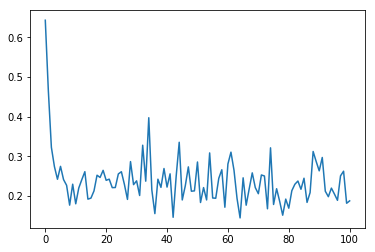

In [29]:
plt.plot(range(len(LOSS)), LOSS)